# Load Pickle Data

In [ ]:
import pandas as pd
from pathlib import Path

data_dir = Path('/mnt/data/factcheck/tweets/similarity_web_data')

print(pd.__version__)
# df = pd.read_pickle(data_dir / 'df_titles.pkl')

In [ ]:
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm.auto import tqdm
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

In [3]:
import json

def load_dict(flnm):
    with open(flnm, 'rt') as f:
        data = json.load(f)
    data = {int(k): v for k, v in data.items()}
    return data

all_to_text = load_dict(data_dir / 'all_text.json')
all_to_vecnos = load_dict(data_dir / 'all_vecno.json')
claims = list(all_to_text.values())

print(len(claims))

203057


In [5]:
claims = list(all_to_text.values())
print('length of claims (texts):', len(claims))

v_torch = torch.load(data_dir / 'all_tensors_pca.pt')

v_numpy = v_torch.numpy()
print('corresponding shape of embeddings:', v_numpy.shape)

length of claims (texts): 203057
corresponding shape of embeddings: (203057, 512)


In [6]:
from sklearn.decomposition import PCA

n = np.linalg.norm(v_numpy, axis=1, keepdims=True)
vectors = v_numpy / n

check = (vectors**2).sum(axis=1)

print(check.mean(), check.std())
print(vectors.shape)

1.0 8.8012634e-08
(203057, 512)


# Choose vectors

In [7]:
rng = np.random.default_rng()

# sub = rng.choice(len(vectors), 50000, replace=False)
# sub.sort()

sub = np.arange(len(vectors))

subvectors = vectors[sub]
subclaims = [claims[i] for i in sub]

# Play

In [7]:
out_path = Path('/mnt/data/factcheck/tweets/clustering/indices')
with open(out_path / f'kmeans_b0_1000.npy', 'rb') as f:
    indices_all = np.load(f, allow_pickle=False)

In [8]:
indices_group = (indices_all==7).nonzero()
for i in range(10):
    index = indices_group[0][i]
    print(claims[index])

Nová podoba hlavního nádraží v Brně ⤵️
Těší mě, že se dnes Praha připojila k aplikaci CityVizor vyvinuté @MinFinCZ. Díky ní může nyní každý z nás nahlédnout do hospodaření hlavního města.  https://t.co/eTUQxjebV4
Největší výstavba Univerzity Karlovy v centru Prahy za posledních sto let 👍  https://t.co/hUdQ4TcWHp
Patříte do skupiny, která se už může očkovat? Bez ohledu na to, kde bydlíte, můžete využít jedno z velkokapacitních center, třeba Národní očkovací centrum v O2 universum v Praze.  https://t.co/oKkl0dpN1A
Jedno z velkokapacitních očkovacích center vyroste v Praze v O2 universum. Dnes jsem se tam byl podívat.  https://t.co/faS1UPspp5
Nejvíc zkušeností mají v pražské porodnici U Apolináře:  https://t.co/XmqbGT2ACG
Ještě pár obrázků. Pražský hrad. TGM. Praha. Děkujeme našim předkům za tu úžasnou krásu.  https://t.co/kNea6mKabg
Apple shání zaměstnance pro pražský Store 👍  https://t.co/ZkjoHOflQF
Zvu vás všechny, přijďte se podívat na krásnou Kramářovu vilu a úchvatný výhled na Prahu

# Histogram

In [9]:
# import pandas as pd
import matplotlib.pyplot as plt

out_path = Path('/mnt/data/factcheck/tweets/clustering/indices')

def get_lengths(batch, clusters):
    with open(out_path / f'kmeans_b{batch}_{clusters}.npy', 'rb') as f:
        clustered_indices_all = np.load(f, allow_pickle=False)
    return [(clustered_indices_all==group_no).sum() 
            for group_no in range(clusters)]

# bins = [1, 2, 50, 100, 150, 200, 250, 500, 1000]
bins = [1, 2, 20, 100, 200, 300, 500, 1000]
    
def get_bars(lengths, bins=bins):
    counts, tweets, names = [], [], []
    for i in range(0, len(bins)-1):
        from_incl = bins[i]
        to_excl = bins[i+1]
        counts.append(sum(from_incl <= l < to_excl for l in lengths))
        tweets.append(sum(l for l in lengths if from_incl <= l < to_excl))
        if from_incl + 1 == to_excl:
            names.append(f'{from_incl}')
        else:
            names.append(f'{from_incl}-\n{to_excl-1}')
    return counts, tweets, names


from collections import defaultdict
data = defaultdict(list)

for exp in range(3):
    lengths5k = get_lengths(exp, 5000)
    lengths10k = get_lengths(exp, 10000)
    lengths15k = get_lengths(exp, 15000)
    
    c5, t5, names = get_bars(lengths5k)
    c10, t10, _ = get_bars(lengths10k)
    c15, t15, _ = get_bars(lengths15k)
    
    data['counts5'].append(c5)
    data['tweets5'].append(t5)
    data['counts10'].append(c10)
    data['tweets10'].append(t10)
    data['counts15'].append(c15)
    data['tweets15'].append(t15)

In [10]:
for k, v in data.items():
    data[k] = np.stack(v, axis=0)

In [11]:
for k, v in data.items():
    mean = v.mean(axis=0)
    mins = v.min(axis=0)
    maxs = v.max(axis=0)
    lower = mean - mins
    upper = maxs - mean
    data[k] = np.stack((mean, lower, upper), axis=0)

In [14]:
data['counts5']

array([[2251.        , 1509.66666667,  557.33333333,  285.33333333,
         185.66666667,  168.        ,   25.        ],
       [  26.        ,    5.66666667,   34.33333333,   11.33333333,
           6.66666667,    7.        ,    3.        ],
       [  28.        ,    8.33333333,   32.66666667,   13.66666667,
           7.33333333,    6.        ,    3.        ]])

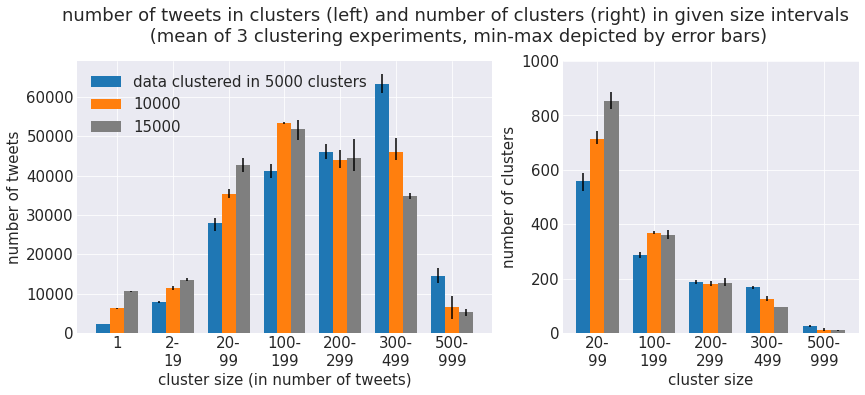

In [16]:
def plot_bars(data, names, labels):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios':(1.4,1)})
    pos = np.arange(len(data['counts5'][0]))
     
    a = ax[0]
    w = 0.25
    a.bar(x=pos-w, height=data['tweets5'][0], width=w, label=labels[0], 
          yerr=data['tweets5'][1:])
    a.bar(x=pos, height=data['tweets10'][0], width=w, label=labels[1], 
          yerr=data['tweets10'][1:])
    a.bar(x=pos+w, height=data['tweets15'][0], width=w, label=labels[2], 
          color='C7', yerr=data['tweets15'][1:])
    # a.bar(x=pos, height=tweets[exp][1], width=w, label=None if exp else labels[1], 
    #       alpha=0.4, color='C1')
    # a.bar(x=pos+w, height=tweets[exp][2], width=w, label=None if exp else labels[2], 
    #       alpha=0.4, color='C7')
    a.set_xticks(pos, names)
    a.set_xlabel('cluster size (in number of tweets)')
    a.set_ylabel('number of tweets')
    # a.set_title('number of tweets in clusters \n in given size intervals')
    a.legend(loc='upper left')
    
    a = ax[1]
    a.bar(x=pos[2:]-w, height=data['counts5'][0][2:], width=w, label=labels[0], 
          yerr=data['counts5'][1:,2:])
    a.bar(x=pos[2:], height=data['counts10'][0][2:], width=w, label=labels[1], 
          yerr=data['counts10'][1:,2:])
    a.bar(x=pos[2:]+w, height=data['counts15'][0][2:], width=w, label=labels[2], 
          color='C7', yerr=data['counts15'][1:,2:])
    a.set_xticks(pos[2:], names[2:])
    a.set_ylim(bottom=0, top=1000)
    a.set_xlabel('cluster size')
    a.set_ylabel('number of clusters')
    # a.set_title('number of clusters \n in given size intervals')
    
    fig.suptitle('number of tweets in clusters (left) and number of clusters (right) in given size intervals'
                 '\n (mean of 3 clustering experiments, min-max depicted by error bars)', y=1.03)
    
    fig.show()
    fig.set_size_inches(14, 5)
    fig.savefig('images/kmeans_bars.png', dpi=300, bbox_inches='tight')

plt.rcParams.update({'font.size': 15})
labels = ['data clustered in 5000 clusters', '10000', '15000']
plot_bars(data, names, labels)

# NMI computation

## Load Labels

In [12]:
import json
from pathlib import Path

anno_path = Path('/mnt/data/factcheck/tweets/similarity_web_annotations')
paths = [f for f in anno_path.iterdir() if f.is_file() and f.suffix == '.json']

annotated_groups = []
for path in paths:
    with path.open('rt') as f:
        included = json.load(f)['included']
        vecnos = np.array([all_to_vecnos[int(i)] for i in included])
        vecnos.sort()
        annotated_groups.append(vecnos)

In [13]:
out_path = Path('/mnt/data/factcheck/tweets/clustering/indices')

def intersection_count(ag: np.ndarray, clu: np.ndarray) -> int:
    return len(np.intersect1d(ag, clu, assume_unique=True))
               
def union_count(ag: np.ndarray, clu: np.ndarray) -> int:
    c = np.concatenate((ag, clu), axis=0)
    return len(np.unique(c))

def compute_ab(clusters_no, name, batch):
    with open(out_path / f'kmeans_b{name}{batch}_{clusters_no}.npy', 'rb') as f:
        clustered_indices_all = np.load(f, allow_pickle=False)

    clustered_groups = []
    for i in range(clustered_indices_all.max()):
        indices = (clustered_indices_all==i).nonzero()[0]
        indices.sort()
        clustered_groups.append(indices)
        
    a_to_c_inters = np.zeros((len(annotated_groups), len(clustered_groups)), dtype=int)
    a_to_c_union = np.zeros((len(annotated_groups), len(clustered_groups)), dtype=int)
    for a_idx, ag in enumerate(annotated_groups):
        inters = np.array([intersection_count(ag, clu) for clu in clustered_groups])
        a_to_c_inters[a_idx, :] = inters
        
        union = np.array([union_count(ag, clu) for clu in clustered_groups])
        a_to_c_union[a_idx, :] = union
    # clust_to_anno = np.zeros((len(clustered_groups), len(annotated_groups)), dtype=int)
    # for c_idx, cg in enumerate(clustered_groups):
    #     ls = np.array([len(np.intersect1d(cg, alu, assume_unique=True)) 
    #                    for alu in annotated_groups])
    #     clust_to_anno[c_idx, :] = ls
    
    iou = a_to_c_inters / a_to_c_union

    iou_max = iou.max(axis=1)
    iou_amax = iou.argmax(axis=1)

    # ag_sizes = np.array([len(a) for a in annotated_groups])
    # cg_sizes = np.array([len(c) for c in clustered_groups])

    # amax_tot = cg_sizes[iou_amax]
    # a = iou_max / ag_sizes # what percentage of us is represented by the best cluster
    # b = iou_max / amax_tot  # what percentage of the cluster represented by us
    return iou_max.mean()

compute_ab(18000, '', 0)

0.12135447719571994

In [14]:
# ab_scores = [compute_ab(cno, 0) for cno in range(1000, 21000, 1000)]
abn_scores = [[compute_ab(cno, '', batch) for cno in range(1000, 21000, 1000)]
              for batch in range(3)]
abu_scores = [[compute_ab(cno, 'unn', batch) for cno in range(1000, 21000, 1000)]
              for batch in range(3)]

In [15]:
len(abu_scores[0]), len(abu_scores[1]), len(abu_scores[2])

(20, 20, 20)

In [16]:
len(abn_scores[0]), len(abn_scores[1]), len(abn_scores[2])

(20, 20, 20)

In [17]:
au_scores = [[ab for ab in abu_scores[i]] for i in range(3)]

an_scores = [[ab for ab in abn_scores[i]] for i in range(3)]

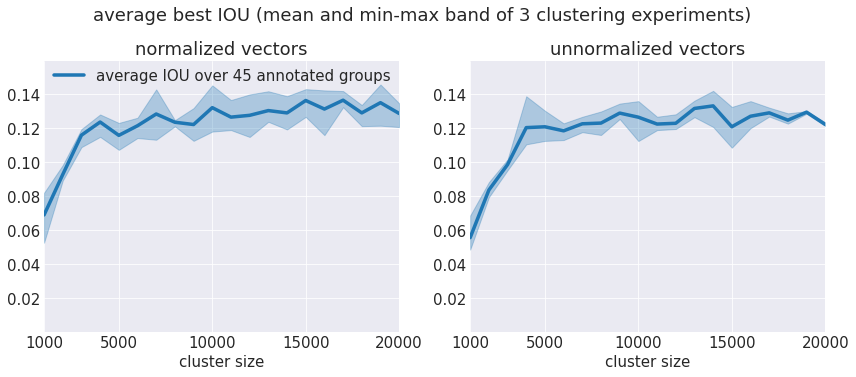

In [19]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(1,2)

keys = list(range(1000, 21000, 1000))

a = ax[0]

a_avg = np.stack(an_scores, axis=0).mean(axis=0)
a_min = np.stack(an_scores, axis=0).min(axis=0)
a_max = np.stack(an_scores, axis=0).max(axis=0)


a.fill_between(keys, a_min, a_max, color='C0', zorder=3, alpha=0.3)

a.plot(keys, a_avg, label='average IOU over 45 annotated groups', linewidth=3.5, zorder=7, color='C0')
a.set_xlabel('cluster size')
pos = [1000, 5000, 10000, 15000, 20000]
names = [f'{p}' for p in pos]
a.set_xticks(pos, names)
a.set_xlim(1000,20000)
yticks_vals = [0.02 * x for x in range(1, 8)]
yticks_names = [f'{i:.2f}' for i in yticks_vals]
a.set_yticks(yticks_vals, yticks_names)
a.set_ylim(0, 0.16)
a.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.02))
a.set_title('normalized vectors')


a = ax[1]

a_avg = np.stack(au_scores, axis=0).mean(axis=0)
a_min = np.stack(au_scores, axis=0).min(axis=0)
a_max = np.stack(au_scores, axis=0).max(axis=0)


a.fill_between(keys, a_min, a_max, color='C0', zorder=3, alpha=0.3)


a.plot(keys, a_avg, label='average IOU over 45 annotated groups', linewidth=3.5, zorder=7, color='C0')
a.set_xlabel('cluster size')
pos = [1000, 5000, 10000, 15000, 20000]
names = [f'{p}' for p in pos]
a.set_xticks(pos, names)
a.set_xlim(1000,20000)
a.set_ylim(0, 0.16)
a.set_yticks(yticks_vals, yticks_names)
# a.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.02))
a.set_title('unnormalized vectors')

fig.suptitle('average best IOU (mean and min-max band of 3 clustering experiments)',
            y=1.03)
fig.set_size_inches(14, 5)
fig.show()
fig.savefig('images/kmeans_plot.png', dpi=300, bbox_inches='tight')

# old version w/ 3 curves

In [18]:
au_scores = [[ab[0] for ab in abu_scores[i]] for i in range(3)]
bu_scores = [[ab[1] for ab in abu_scores[i]] for i in range(3)]
zu_scores = [[2 * a * b / (a + b) for a, b in zip(au_scores[i], bu_scores[i])]
            for i in range(3)]

an_scores = [[ab[0] for ab in abn_scores[i]] for i in range(3)]
bn_scores = [[ab[1] for ab in abn_scores[i]] for i in range(3)]
zn_scores = [[2 * a * b / (a + b) for a, b in zip(an_scores[i], bn_scores[i])]
            for i in range(3)]

In [19]:
# Randomized generation only if we do not have a triplet

# a_arr = np.array([ab[0] for ab in ab_scores])
# b_arr = np.array([ab[1] for ab in ab_scores])

# l = len(a_arr)
# a_scores = [a_arr, 
#             a_arr + np.random.rand(l) * 0.05,
#             a_arr + np.random.rand(l) * 0.05]

# b_scores = [b_arr, 
#             b_arr + np.random.rand(l) * 0.05,
#             b_arr + np.random.rand(l) * 0.05]

# z_scores = [2 * a * b / (a + b) for a, b in zip(a_scores, b_scores)]

In [21]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(1,2)

keys = list(range(1000, 21000, 1000))

a = ax[0]

a_avg = np.stack(an_scores, axis=0).mean(axis=0)
b_avg = np.stack(bn_scores, axis=0).mean(axis=0)
z_avg = np.stack(zn_scores, axis=0).mean(axis=0)

a_min = np.stack(an_scores, axis=0).min(axis=0)
b_min = np.stack(bn_scores, axis=0).min(axis=0)
z_min = np.stack(zn_scores, axis=0).min(axis=0)

a_max = np.stack(an_scores, axis=0).max(axis=0)
b_max = np.stack(bn_scores, axis=0).max(axis=0)
z_max = np.stack(zn_scores, axis=0).max(axis=0)

a.fill_between(keys, a_min, a_max, color='C0', zorder=3, alpha=0.3)
a.fill_between(keys, z_min, z_max, color='C7', zorder=4, alpha=0.3)
a.fill_between(keys, b_min, b_max, color='C1', zorder=2, alpha=0.3)

a.plot(keys, a_avg, label='average $\mathit{a}$ over 45 annotated groups', linewidth=3.5, zorder=7, color='C0')
a.plot(keys, z_avg, label='average $\mathit{z}$ ...', linewidth=3.5, zorder=8, color='C7')
a.plot(keys, b_avg, label='average $\mathit{b}$ ...', linewidth=3.5, zorder=6, color='C1')
a.set_xlabel('cluster size')
pos = [1000, 5000, 10000, 15000, 20000]
names = [f'{p}' for p in pos]
a.set_xticks(pos, names)
a.set_xlim(1000,20000)
a.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.02))
a.set_title('normalized vectors')


a = ax[1]

a_avg = np.stack(au_scores, axis=0).mean(axis=0)
b_avg = np.stack(bu_scores, axis=0).mean(axis=0)
z_avg = np.stack(zu_scores, axis=0).mean(axis=0)

a_min = np.stack(au_scores, axis=0).min(axis=0)
b_min = np.stack(bu_scores, axis=0).min(axis=0)
z_min = np.stack(zu_scores, axis=0).min(axis=0)

a_max = np.stack(au_scores, axis=0).max(axis=0)
b_max = np.stack(bu_scores, axis=0).max(axis=0)
z_max = np.stack(zu_scores, axis=0).max(axis=0)

a.fill_between(keys, a_min, a_max, color='C0', zorder=3, alpha=0.3)
a.fill_between(keys, z_min, z_max, color='C7', zorder=4, alpha=0.3)
a.fill_between(keys, b_min, b_max, color='C1', zorder=2, alpha=0.3)

a.plot(keys, a_avg, label='average $\mathit{a}$ over 45 annotated groups', linewidth=3.5, zorder=7, color='C0')
a.plot(keys, z_avg, label='average $\mathit{z}$ ...', linewidth=3.5, zorder=8, color='C7')
a.plot(keys, b_avg, label='average $\mathit{b}$ ...', linewidth=3.5, zorder=6, color='C1')
a.set_xlabel('cluster size')
pos = [1000, 5000, 10000, 15000, 20000]
names = [f'{p}' for p in pos]
a.set_xticks(pos, names)
a.set_xlim(1000,20000)
# a.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.02))
a.set_title('unnormalized vectors')

fig.suptitle('average $\mathit{a}$, $\mathit{b}$ and $\mathit{z}$ (mean and min-max band of 3 clustering experiments)',
            y=1.03)
fig.set_size_inches(14, 5)
fig.show()
fig.savefig('images/kmeans_plot.png', dpi=300, bbox_inches='tight')